# Analyse Missigness of Patient Data for Each Variable Bucket

## Baseline Variables

In [2]:
# Importing the libraries 
import pandas as pd 
import missingno as msno 
import matplotlib.pyplot as plt
import numpy as np

In [8]:
# Loading the dataset (all tables that contain baseline variables = information about patients before the procedure)
# merge those that are available for all and not just a subset of patients
path = "C:\\Users\\Elly\\Dropbox\\Biotronik\\data\\191218 C1503 BIOSOLVE-IV - csv datasets\\"
file_abr = ["ENROL","IE","EQ5D","MHRF","ISBP","ECG","CEBP","SCBP","LC"]


def delete_columns(cols2del, data):
    for col in cols2del:
        if col in data.columns:
            del data[col]
    return data

# read all information into one big pandas dataframe
frame = pd.read_csv(path + file_abr[0] + ".csv", header=0, sep=",")
frame = delete_columns(["visit","enstudyid","encipv","ecrfvers","parent_record_id","record_id","record_status","record_status_text"], frame)

for filename in file_abr[1:len(file_abr)]:
    df = pd.read_csv(path + filename + ".csv", header=0, sep=",")
    
    # take the eq5d questionair before procedure (not follow up)
    if filename == "EQ5D":
        df = df[df['visit']=="Screening 2.0"]
    
    # take the ecg values for screening at not for "hospital discharge"
    if filename == "ECG":
        df = df[(df["visit"] == "Screening") | (df["visit"] == "Screening 2.0")]
        
    # some patients have more than one target lesion!
    if filename == "LC":
        df = df[["siteid","studyid","subjid","lccassmap","lcid","lclesloc","lcvessel","lctimipr","lcaccaha","lccalccs","lcvangul","lctortsy"
                ,"lcbifurc","lcecntry","lcthrmbs","lclenv","lcrvdv","lcdsv"]]
        
    
    df = delete_columns(["visit","enstudyid","encipv","ecrfvers","parent_record_id","record_id","record_status","record_status_text"],
                         df)

        
    frame = pd.merge(frame,df,on=["studyid","subjid","siteid"], how='outer')

print("Table size:", frame.shape)
frame.head()


Table size: (1840, 143)


,studyid,siteid,subjid,endtc,age,sex,entim,incl01,incl02,incl03,...,lcaccaha,lccalccs,lcvangul,lctortsy,lcbifurc,lcecntry,lcthrmbs,lclenv,lcrvdv,lcdsv
0,C1503,AUS012,C1503-AUS012-001,16DEC16,49,Male,11:00:00,Yes,Yes,Yes,...,Type B2,Mild,Moderate (>= 45 - < 90°),Moderate,No,Concentric,No,12.0,3.0,80.0
1,C1503,AUS012,C1503-AUS012-002,16DEC16,70,Male,10:40:00,Yes,Yes,Yes,...,Type C,Mild,Moderate (>= 45 - < 90°),Moderate,No,Eccentric,No,20.0,3.0,85.0
2,C1503,AUS012,C1503-AUS012-003,02JUN17,46,Male,8:03:00,Yes,Yes,Yes,...,Type B2,Mild,Moderate (>= 45 - < 90°),Moderate,No,Concentric,No,15.0,3.5,90.0
3,C1503,AUS012,C1503-AUS012-004,21JUL17,40,Male,9:57:00,Yes,Yes,Yes,...,Type B2,Moderate,Moderate (>= 45 - < 90°),Moderate,No,Concentric,No,20.0,3.5,90.0
4,C1503,AUS012,C1503-AUS012-005,26JUL17,65,Female,10:51:00,Yes,Yes,Yes,...,Type B1,None,None (< 45°),Little,No,Eccentric,No,15.0,3.0,95.0


 Question:
 - How handle data that are not available for all patients (e.g. PCISUB) - one patient can have no entry or multiple?
 
 Data just available for subset of patients:
 - "MHRFSUB"
 - "PCISUB"
 - "LC" --> one patient can have more than one treated target lesion

<BarContainer object of 138 artists>

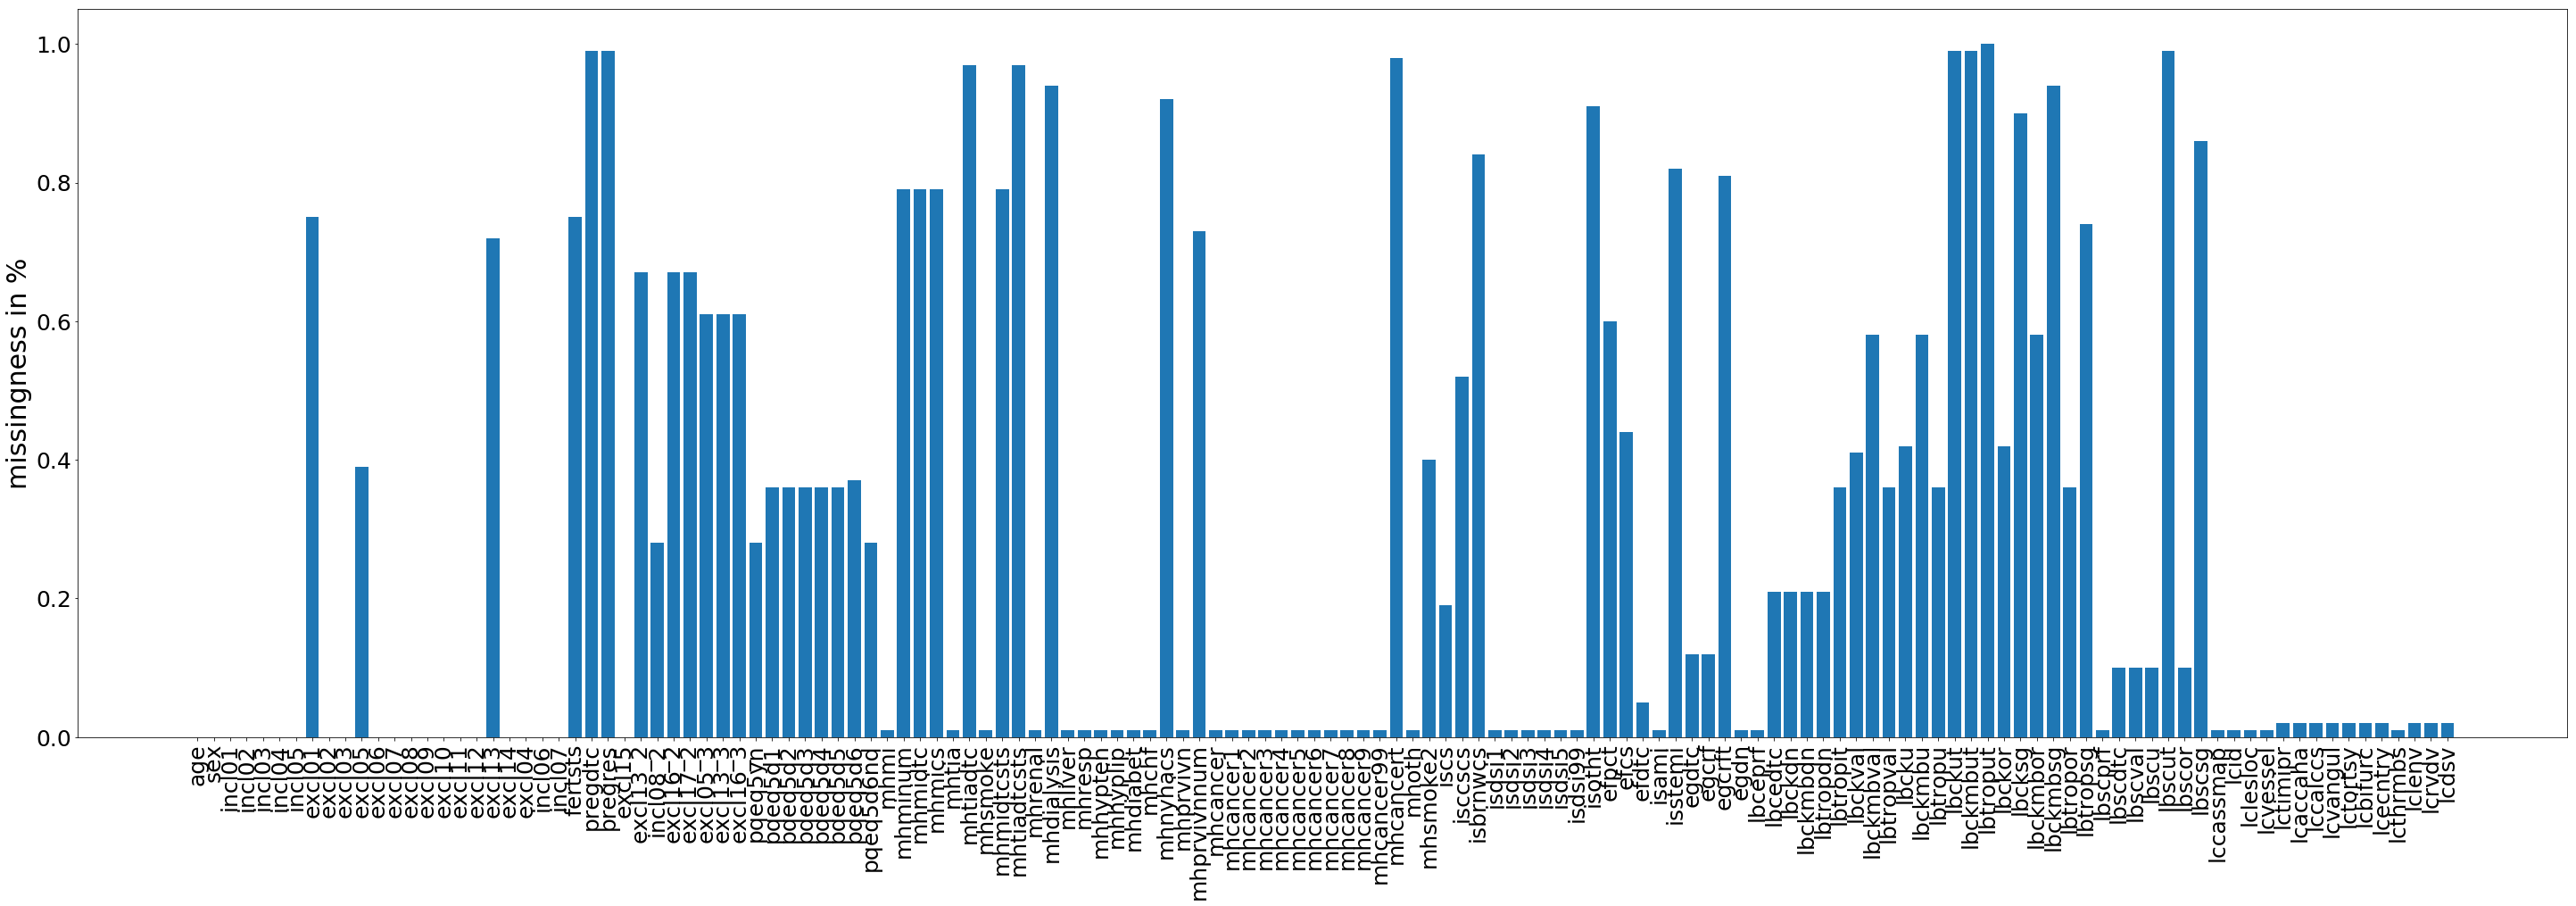

In [9]:
# drop non-feature columns
feature_columns = frame.columns.drop(['siteid','studyid','subjid','entim','endtc'])

null_counts = np.round(frame[feature_columns].isnull().sum()/len(frame[feature_columns]),2)
plt.figure(figsize=(50,15))
plt.xticks(np.arange(len(null_counts)),null_counts.index,fontsize=25,rotation=90)
plt.ylabel('missingness in %', fontsize=30)
plt.yticks(fontsize = 25)
plt.bar(np.arange(len(null_counts)),null_counts)

- quite a lot of missing data (almost all feature columns contain missing values and the fraction of rows with missing data can be substantial)
- Next step: calculate for different thresholds (0,20,40,60,80,100) t following information:
    - fraction of variables that has as most t% missigness
    - pro variable (at most t% missigness): number of patients where variable is not missing

In [157]:
# set threshold range
threshold = range(20,101,20)
# create multi-index with (count, fraction, number of NaN sequences) per feature column
iterables = [feature_columns,['count','fraction']]
index = pd.MultiIndex.from_product(iterables,names=['feature','stat'])

nan_dict = {}

# for every feature column
for t in threshold:
    # create empty data frame for each threshold
    nan_df = pd.DataFrame(data=None,columns=index)
    nan_df["subjid"]= frame["subjid"]
    for c in feature_columns:
        # total number of rows with missing data
        nan_count = frame[c].isnull().sum()

        # total fraction of rows with missing data
        nan_fraction = np.round(nan_count * 100.0/len(frame),2)

        # row indices for missing data
        nan_indices = pd.isnull(frame[c]).to_numpy().nonzero()[0]

        # if fraction is maximal the current threshold
        if nan_fraction <= t:
            nan_df[c,'count'][nan_indices] = np.repeat(nan_count, len(nan_indices))
            nan_df[c,'fraction'][nan_indices] = np.repeat(nan_fraction, len(nan_indices))

        else:
            nan_df[c,'count'][nan_indices] = np.repeat(len(frame), len(nan_indices))
            nan_df[c,'fraction'][nan_indices] = np.repeat(100.0, len(nan_indices))
    nan_dict[t] = nan_df
    

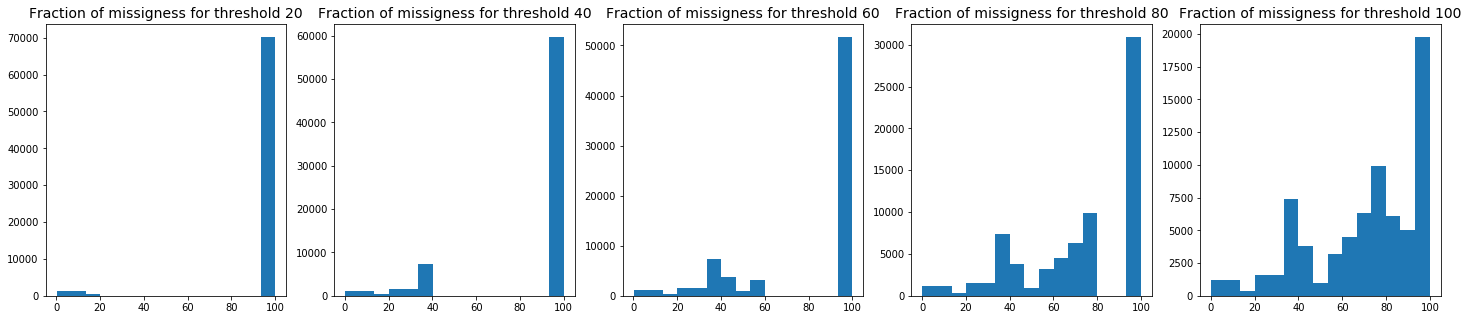

In [158]:
# extract all fraction from nan_dict
fractions_dict = dict(((key,value.xs('fraction',level='stat',axis=1)) for key, value in nan_dict.items()))

def draw_histograms(df_dict, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(25,5))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        plt.hist([x for x in df_dict[var_name].values.flatten() if ~np.isnan(x)],bins=15, label=key)
        ax.set_title("Fraction of missigness for threshold " + str(var_name), fontsize = 14)
    #fig.tight_layout()  # Improves appearance a bit.
    plt.show()

draw_histograms(fractions_dict, threshold,1,len(threshold))

#for key, value in fractions_dict.items():
#plt.hist([x for x in value.values.flatten() if ~np.isnan(x)],bins=20, label=key)
    
#plt.legend(loc='upper left')
#plt.xlabel('fraction of rows with missing data per threshold');
#plt.show()



How to interpret histogram:
Different colors show different set thresholds for missigness. Each feature column (variable) that have a missingness in the baseline patient data higher than the threshold is considered completely absent in all patients (--> missingness = 100% --> absence in every patient, even if it is sometimes there).
Y-axis shows the number of times a missigness is in the data. We have many feature columns that have a very high missigness even with the threshold set to 100%, meaning we are looking at the actual missigness percentages.